In [8]:
# Use this cell to regroup all your imports
%load_ext autoreload
%autoreload 2
from deep_currents.model import Model
from sklearn import set_config; set_config(display='diagram')
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


ModuleNotFoundError: No module named 'deep_currents'

# Load data

## Train data

In [ ]:
m = Model()

In [ ]:
m.open_data()

## Test data

# Prepare data

## Build pipeline for preproc data

This pipeline is important to adjust the data to enter in the DL model.

We are applying two corrections:
- KNNImputer: to impute value when we have missing data. It will get the closest value to complete
- Standardcale: to use ML and DL models, we have to rescale all variables to the same scale. I choose Standard sclae, but it will depends on the hist distribuition of the variations (normal distribution and outliers)

In [2]:
plt.hist(m.X[0][17:-1])

NameError: name 'plt' is not defined

In [3]:
plt.hist(m.X[0][0:16])

NameError: name 'plt' is not defined

In [4]:
m.preproc()

NameError: name 'm' is not defined

## Preproc data

Fit the data ⬇️

In [9]:
m.preproc_fit()

# Machine Learning

In [10]:
m.basic_ml(model='ridge')

Pipeline(steps=[('standardscaler', StandardScaler()), ('ridge', Ridge())])

In [11]:
m.validation_split(test_size=0.3)

In [12]:
m.score_baseline()

MSE = 16.276942909686902


2.9770894782485766


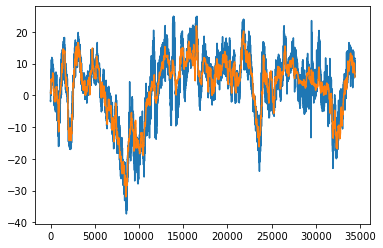

In [13]:
m.predict_baseline()

# Deep Learning

## Preproc data

In [64]:
m.preproc_transform()

## Initialize model

See the shape of your data and try insert the number of columns in the input_dim value

In [69]:
m.define_model()


learning rate: 0.001
Loss = msle
Metric = mae
Opt = adam
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_37 (Dense)             (None, 120)               80040     
_________________________________________________________________
dense_38 (Dense)             (None, 80)                9680      
_________________________________________________________________
dense_39 (Dense)             (None, 40)                3240      
_________________________________________________________________
dense_40 (Dense)             (None, 20)                820       
_________________________________________________________________
dense_41 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_42 (Dense)             (None, 20)                420       
______________________________________________________________

Initialize modal and show its summary

## Fit model to your data

In [70]:
m.validation_split(test_size=0.3, deep=True)

In [71]:
m.learning_rate()

In [72]:
m.model_fit()

Early stop with patience 10
Batch size 32
Epoch = 100
Validation Split = 30%
Epoch 1/300
1054/1054 [==============================] - 3s 3ms/step - loss: 0.5887 - mae: 6.1113 - val_loss: 0.5587 - val_mae: 5.6088
Epoch 2/300
1054/1054 [==============================] - 3s 3ms/step - loss: 0.4558 - mae: 5.6914 - val_loss: 0.3894 - val_mae: 5.5068
Epoch 3/300
1054/1054 [==============================] - 3s 3ms/step - loss: 0.4083 - mae: 5.4880 - val_loss: 0.3721 - val_mae: 5.3985
Epoch 4/300
1054/1054 [==============================] - 3s 3ms/step - loss: 0.3796 - mae: 5.3640 - val_loss: 0.3597 - val_mae: 5.1429
Epoch 5/300
1054/1054 [==============================] - 3s 3ms/step - loss: 0.3552 - mae: 5.2404 - val_loss: 0.3041 - val_mae: 5.0572
Epoch 6/300
1054/1054 [==============================] - 3s 2ms/step - loss: 0.3254 - mae: 5.0810 - val_loss: 0.3599 - val_mae: 5.1910
Epoch 7/300
1054/1054 [==============================] - 3s 3ms/step - loss: 0.3116 - mae: 5.0903 - val_loss: 0.3

## Evaluate the model

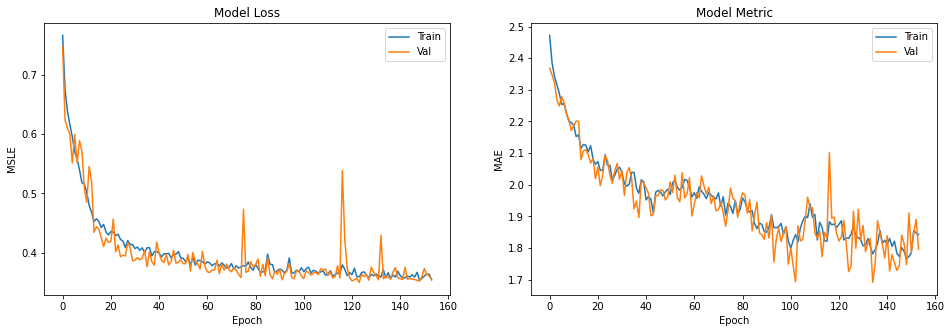

In [73]:
m.plot_history()

In [74]:
m.model_evaluate()

MSLE = 0.123694509267807
MAE = 3.2725911140441895


## Predict the data

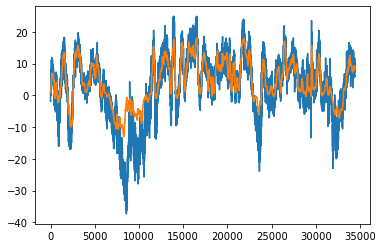

In [77]:
m.predict_deep()

# Time Series Analisys

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomp_add = seasonal_decompose(y, model="additive")
decomp_mult = seasonal_decompose(y, model="multiplicative")

In [ ]:
decomp_mult.plot();

In [ ]:
decomp_add.plot();

### Split train test data - the data is already Standard Scaled


In [ ]:
len_ = int(0.8*df.shape[0])
df_train = df[:len_]
df_test = df[len_:]
print(df_train.shape)
print(df_test.shape)

In [ ]:
print("train shape: {}, test shape: {}".format(df_train.shape,df_test.shape))

## Create (X,y)

In [ ]:
import numpy as np

def subsample_sequence(df, length):
    """
    Given the initial dataframe `df`, return a shorter dataframe sequence of length `length`.
    This shorter sequence should be selected at random.
    """
    
    last_possible = df.shape[0] - length
    
    random_start = np.random.randint(0, last_possible)
    df_sample = df[random_start: random_start+length]
    
    return df_sample

def compute_means(X, df_mean):
    '''utils'''
    # Compute means of X
    means = X.mean()
    
    # Case if ALL values of at least one feature of X are NaN, then reaplace with the whole df_mean
    if means.isna().sum() != 0:
        means.fillna(df_mean, inplace=True)
        
    return means

def split_subsample_sequence(df, length, df_mean=None):
    """Return one single sample (Xi, yi) containing one sequence each of length `length`"""
    features_names = ['TEMP', 'DEWP', 'PRES', 'Ir', 'Is', 'Iws']
    
    # Trick to save time during the recursive calls
    if df_mean is None:
        df_mean = df[features_names].mean()
        
    df_subsample = subsample_sequence(df, length).copy()
    
    # Let's drop any row without a target! We need targets to fit our model
    df_subsample.dropna(how='any', subset=['pm2.5'], inplace=True)
    
    # Create y_sample
    if df_subsample.shape[0] == 0: # Case if there is no targets at all remaining
        return split_subsample_sequence(df, length, df_mean) # Redraw by recursive call until it's not the case anymore
    y_sample = df_subsample[['pm2.5']]
    
    # Create X_sample
    X_sample = df_subsample[features_names]
    if X_sample.isna().sum().sum() !=0:  # Case X_sample has some NaNs
        X_sample = X_sample.fillna(compute_means(X_sample, df_mean))
        
    return np.array(X_sample), np.array(y_sample)

def get_X_y(df, sequence_lengths):
    '''Return a dataset (X, y)'''
    X, y = [], []

    for length in sequence_lengths:
        xi, yi = split_subsample_sequence(df, length)
        X.append(xi)
        y.append(yi)
        
    return X, y

In [ ]:
train_size = 1000
test_size = round(0.2 * train_size)

min_seq_len = 15
max_seq_len = 30

In [ ]:
# Let's generate some train/test sets
sequence_lengths_train = np.random.randint(low=min_seq_len, high=max_seq_len, size=train_size)
X_train, y_train = get_X_y(df_train, sequence_lengths_train)

sequence_lengths_test = np.random.randint(low=min_seq_len, high=max_seq_len, size=test_size)
X_test, y_test = get_X_y(df_test, sequence_lengths_test)

## Padding sequences with differences in lenght

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

X_train_pad = pad_sequences(X_train, value=-1000., dtype=float, padding='post', maxlen=30)
y_train_pad = pad_sequences(y_train, value=-1000., dtype=float, padding='post', maxlen=30)

X_test_pad = pad_sequences(X_test, value=-1000., dtype=float, padding='post', maxlen=30)
y_test_pad = pad_sequences(y_test, value=-1000., dtype=float, padding='post', maxlen=30)

X_train_pad.shape

## Validation baseline with mean

In [ ]:
# We here decide to predict the mean of the train set y_train
y_pred = np.mean([_ for elt in y_train for _ in elt])
bench_res = np.mean(np.abs([_-y_pred for elt in y_test for _ in elt]))

print(f'Benchmark MAE on the test set : {bench_res:.4f}')

## Deep Learning Model

In [ ]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

def init_model():
    
    model = models.Sequential()
    model.add(layers.Masking(mask_value=-1000., input_shape=(30,6)))
    model.add(layers.LSTM(20, return_sequences=True, activation='tanh'))
    model.add(layers.LSTM(10, return_sequences=True, activation='tanh'))
    model.add(layers.Dense(5, activation='relu'))
    model.add(layers.Dense(1, activation='linear'))
    
    model.compile(loss='mse', 
                  optimizer='rmsprop', 
                  metrics=['mae'])
    model.compile(loss='mse', 
                  optimizer=RMSprop(learning_rate=0.0003), 
                  metrics=['mae'])
    
    return model

init_model().summary()

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

model = init_model()

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5, restore_best_weights=True)

history = model.fit(X_train_pad, y_train_pad,
            validation_split=0.2,
            epochs=1000, 
            batch_size=64,
            callbacks=[es], verbose=0)

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])

In [ ]:
res = model.evaluate(X_test_pad, y_test_pad, verbose=0)

print(f'MAE on the test set : {res[1]:.4f}, or {res[1]/bench_res:.2f} times the benchmark')

In [ ]:
plt.figure(figsize=(17,3))
for id_plot, id_seq in enumerate(np.random.randint(low=0,high=len(X_test),size=5)):
    plt.subplot(1, 5, id_plot+1)
    plt.plot(y_test[id_seq], label='truth')
    plt.plot(model.predict(X_test_pad)[id_seq], label='pred')
    plt.ylim(ymin=0)
plt.legend();

In [ ]:
from statsmodels.tsa.stattools import adfuller
print('p-value: ', adfuller(df_train["Sales"])[1])